# Modelling

In this notebook we will finally start working on getting a model to predict who may win in a game of chess given our variables. 

## Loading the data and libraries

In [37]:
#basic/typical packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from itertools import combinations

#sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score, log_loss, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [2]:
train = pd.read_pickle('train_df.pkl')
test = pd.read_pickle('test_df.pkl')

In [3]:
train.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_e87,Counts_name_e88,Counts_name_e90,Counts_name_e91,Counts_name_e92,Counts_name_e94,Counts_name_e95,Counts_name_e97,Counts_name_e98,winner_label
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,2
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


Recall that the winner_label is the target variable, and values of 0 indicates that the players who chose black won, 1 indicates a draw, and 2 indicates that players who chose white won.

In [4]:
y = train['winner_label']
X = train.drop(columns = 'winner_label')

In [5]:
X.head()

,rated,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,time_allotted,increment,...,Counts_name_e81,Counts_name_e87,Counts_name_e88,Counts_name_e90,Counts_name_e91,Counts_name_e92,Counts_name_e94,Counts_name_e95,Counts_name_e97,Counts_name_e98
2858,0,1,0,0,0.163828,-0.976846,-0.378900,-0.648908,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0
7948,1,0,0,1,0.790929,2.243676,1.463170,1.852692,-0.397451,0.351493,...,0,0,0,0,0,0,0,0,0,0
15696,1,0,0,1,1.298583,-0.218264,-0.113780,-0.291536,-0.280300,-0.010609,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,-1.538306,-0.635484,1.783380,0.065835,0.071153,1.799901,...,0,0,0,0,0,0,0,0,0,0
14894,1,0,0,1,0.343000,-0.011379,0.020502,0.065835,-0.221724,-0.372712,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_test = test['winner_label']
X_test = test.drop(columns = 'winner_label')

Let's try a few different models, and compare later to pick the best one.

## Logistic Regression

Let's first get some basic accuracy scores with the default hyperparameters to quickly see how this model does initially. 

In [7]:
#note when using the default solver='lbfgs', we get an error about str not being able to decode, 
#it seems like it is related to the victory status columns datatypes
#in any case, the solvers: 'newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’, all are for multiclass classification problems
#we will just try newton-cg here and then the rest later in grid search
lr = LogisticRegression(solver='newton-cg', random_state=42)

lr.fit(X, y)

LogisticRegression(random_state=42, solver='newton-cg')

In [8]:
#let's just check the training score quickly
lr.score(X, y)

0.8297055950886005

In [9]:
y_pred = lr.predict(X_test)

#test score
lr.score(X_test, y_test)

0.756852898095836

So these scores are pretty good already, but we should try to do better, along with some other evaluation metrics. Let's start with Grid Search for hyperparameter tuning.

Edit: unfortunately, all multiclass solvers (except newton-cg) caused some errors and increased run time too much, so only newton-cg was used here. Although, from a few singular trial and error runs it did seem like this was the best solver anyways, at least in terms of the accuracy metric.

In [97]:
#not all solvers support the l1 penalty, so we won't try it and just leave the default value to keep run time low
parameters = {'solver': ['newton-cg'], 
              'max_iter': [25, 50, 75, 100, 125]}

lr = LogisticRegression(random_state=42)

clf = GridSearchCV(lr, parameters)

clf.fit(X, y)

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'max_iter': [25, 50, 75, 100, 125],
                         'solver': ['newton-cg']})

In [98]:
clf.score(X, y)

0.8297055950886005

In [99]:
clf.score(X_test, y_test)

0.756852898095836

In [100]:
clf.best_params_

{'max_iter': 25, 'solver': 'newton-cg'}

So thanks to grid search we have the best parameters here, and it seems like the accuracy's didn't change at all. Adding a range for the C parameter wasn't done here because initially when tried it increased run times too much. Also, since it is the only other parameter of interest, we can look at it seperately with a validation curve.

In [101]:
model = LogisticRegression(solver = 'newton-cg', random_state=42, max_iter=25)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              param_name="C", 
                                              param_range=[0.001, 0.01, 0.1, 1, 10, 100], 
                                              cv=5)

C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\RaviB\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to conver

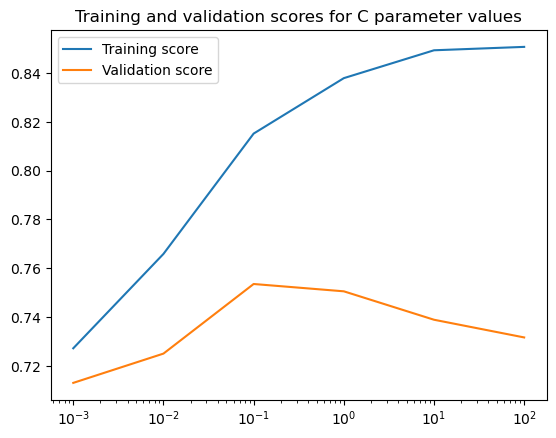

In [102]:
train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

#the C parameter ranges increase exponentially, so we need to take the log of it to get a better visual
plt.semilogx([0.001, 0.01, 0.1, 1, 10, 100], train_scores_mean, label="Training score")
plt.semilogx([0.001, 0.01, 0.1, 1, 10, 100], valid_scores_mean, label="Validation score")
plt.title('Training and validation scores for C parameter values')
plt.legend()
plt.show()

So from this curve it seems like the best value for C is 0.01. After this value the training score increasing and validation score decreases, indicating overfitting.

### Evaluation Metrics for Logistic Regression

Now that the best model and its best hyperparameters are found, let's look at some evaluation metrics to compare to other models.

In [13]:
#so here is the best model we found
log_reg = LogisticRegression(solver = 'newton-cg', random_state=42, max_iter=25, C=0.1)

log_reg.fit(X, y)

LogisticRegression(C=0.1, max_iter=25, random_state=42, solver='newton-cg')

**Let's get the training and testing accuracies.**

In [14]:
log_reg_training_score = log_reg.score(X, y)

log_reg_testing_score = log_reg.score(X_test, y_test)

print('Logistic Regression training score:', log_reg_training_score)
print('Logistic Regression testing score:', log_reg_testing_score)

Logistic Regression training score: 0.811148318682852
Logistic Regression testing score: 0.7656413475622516


So you can see here with the optimal C value, the training score went down just a bit, and the validation score went up just a bit. This is good, but not that significant really.

**Let's get the F1 scores.**

When using the f1 score we use both the macro and weighted values for the average parameter, which is required for multiclass problems. The weighted average simply adds weights to make up for an imbalanced dataset, which this dataset is due to the lack of draws. That being said, we don't care quite as much about predicting draws (since obviously factors of a chess game that lead to a draw aren't desirable), and the black and white winners are balanced, hence why we are checking them both here.

In [15]:
y_pred = log_reg.predict(X_test)

f1_macro_lr = f1_score(y_test, y_pred, average='macro')
f1_weighted_lr = f1_score(y_test, y_pred, average='weighted')

print('The F1 score is:', f1_macro_lr)

print('The weighted F1 score is:', f1_weighted_lr)

The F1 score is: 0.816002329121901
The weighted F1 score is: 0.7658555334704005


**Now let's get the log loss.** 

We can use this to compare later. Note here that the lower the value the better.

In [53]:
y_pred_probs = log_reg.predict_proba(X_test)

log_reg_logloss = log_loss(y_test, y_pred_probs)

print('The log loss for logistic regression is:', log_reg_logloss)

The log loss for logistic regression is: 0.5106299633879651


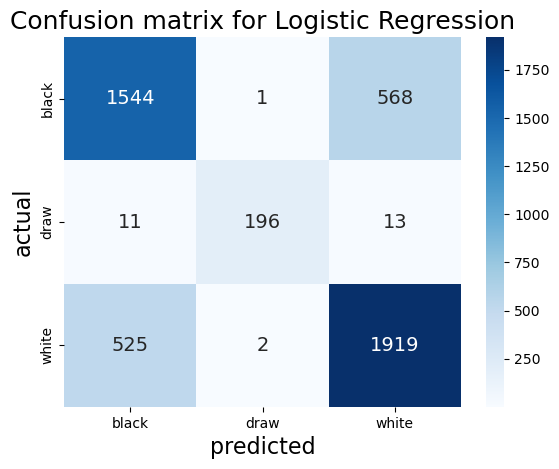

In [17]:
#now let's get the confusion matrix to see how it does
con_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for Logistic Regression', fontsize=18)
plt.show()

**We can also get ROC curves.**

To do this, we are borrowing code from this link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html.

Essentially, what we are doing here is getting ROC curves that compares each target label to other target labels individually. So, for example, if we are comparing predicting white winners or a draw, then the ROC curve will treat both of them as the positive case, and plot both of those ROC curves. It will then also plot an average of the two ROC curves. Doing this for other combinations will net us three different plots. 

We can easily repeat this for the other models as well.

In [54]:
#these are just some things we need for the borrowed code to work - easier to define them seperatly here

#this gives use the target labels as pairs, to do one vs one ROC curves
pair_list = list(combinations(np.unique(y), 2))

#just grid space
fpr_grid = np.linspace(0.0, 1.0, 1000)

#just renaming a variable for ease
y_score = y_pred_probs

#we need the actual target names, instead of just the numbers. Recall 0 is black, 1 is draw, and 2 is white
target_names = np.array(['black', 'draw', 'white'])

#this just gets what classes we have. You can double check by running: label_binarizer.classes_
label_binarizer = LabelBinarizer().fit(y)

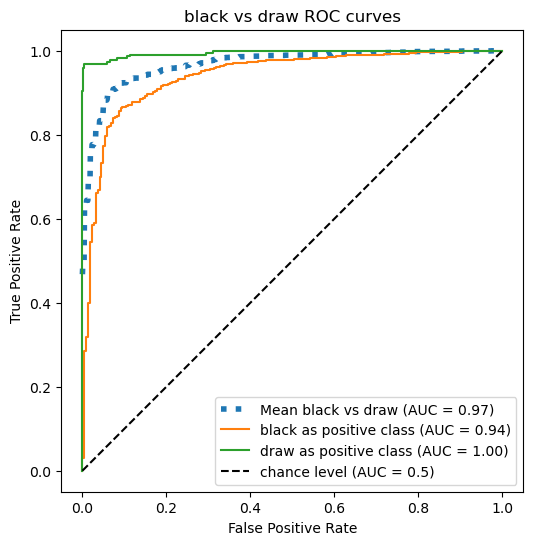

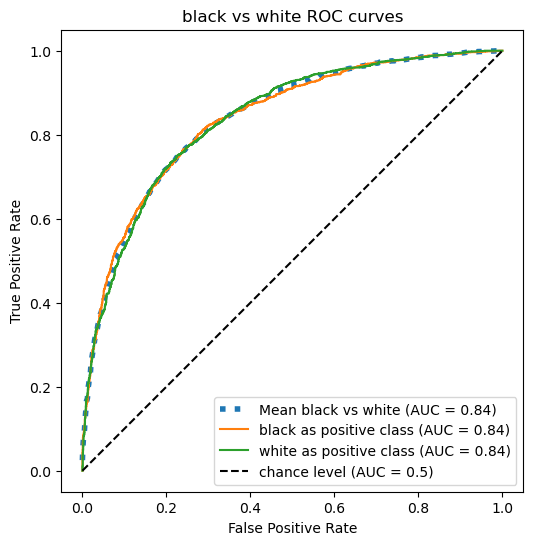

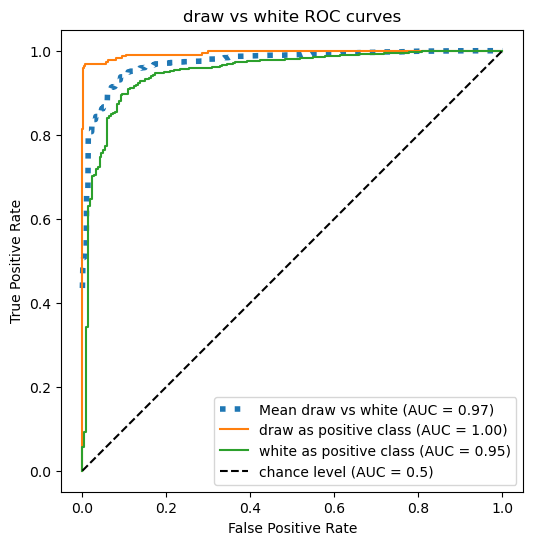

Macro-averaged One-vs-One ROC AUC score:
0.93


In [55]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)
    
    #modifying code to work with the labels in this dataset - just renaming from number to categries
    cat1 = {0:'black', 1:'draw', 2:'white'}[label_a]
    cat2 = {0:'black', 1:'draw', 2:'white'}[label_b]

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {cat1} vs {cat2} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{cat1} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{cat2} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    

        
        
    plt.title(f"{target_names[idx_a]} vs {cat2} ROC curves")
    plt.legend()
    plt.show()

lr_1v1_auc = np.average(pair_scores)
print(f"Macro-averaged One-vs-One ROC AUC score:\n{lr_1v1_auc:.2f}")

**Some observations about the ROC AUC plots:** When you look at the ROC curves where draw is the positive class, the AUC score is 1. This is in line with the confusion matrix above, since the model predicts draws quite well. Then, when black or white are the positive class, and we are comparing them to the draw label, the AUC score goes down. Again, this makes sense since from the confusion matrix does have a noticeable error rate when predicting black or white, though it is not high. 

Then when you look at black vs white ROC curve, you can see all AUC scores and ROC curves are the same. This is certainly in line with the confusion matrix above as well, since when the model falsely predicts black or white, it usually is because it predicted the opposite winner, and not a draw. In any case, when you average all these AUC scores, it is 0.93 which is great.

## Random Forest

Again let's quickly try the default values here for random forest.

In [10]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X, y)

RandomForestClassifier()

In [11]:
rf.score(X, y)

1.0

In [12]:
rf.score(X_test, y_test)

0.7154216363255911

Random forest overfits on the training data here, but the testing data has a better score. The fitting time here was somewhat long though, so default values will definitely not be kept. Let's move onto Grid Search now.

In [47]:
parameters = {'n_estimators': [50, 75, 100, 125], 
              'max_depth': [3, 5, 7], 
              'min_samples_split': [3, 5, 7], 
              'min_samples_leaf':[1, 3, 5]}

rf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(rf, parameters)

clf.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 75, 100, 125]})

In [50]:
clf.score(X, y)

0.690316729454444

In [48]:
clf.score(X_test, y_test)

0.6626909395270977

In [49]:
clf.best_params_

{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 125}

The best parameters are given above. Since the max_depth and n_estimators had the max of the values selected as the best hyperparameter values, let's try looking at them individually with a validation curve, and with a larger range of values to check. This will give us a better look at whats going on, and save on run time.

In [8]:
model = RandomForestClassifier(random_state=42, max_depth=7, min_samples_split=3)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              param_name="n_estimators", 
                                              param_range=[50, 75, 100, 125, 150, 200, 250], 
                                              cv=5)

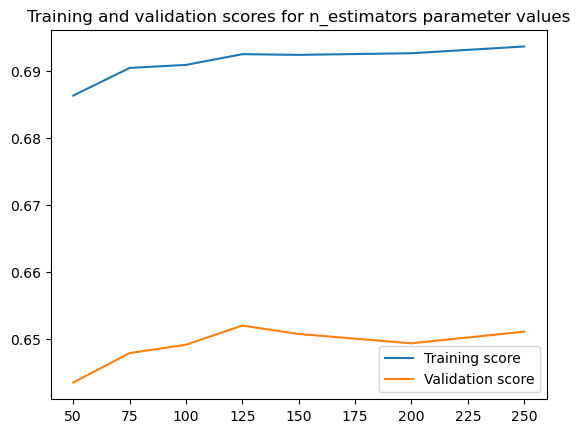

In [9]:
train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

#the C parameter ranges increase exponentially, so we need to take the log of it to get a better visual
plt.plot([50, 75, 100, 125, 150, 200, 250], train_scores_mean, label="Training score")
plt.plot([50, 75, 100, 125, 150, 200, 250], valid_scores_mean, label="Validation score")
plt.title('Training and validation scores for n_estimators parameter values')
plt.legend()
plt.show()

So it seems like the scores don't vary too much, but n_estimators=125 is indeed the best value. Let's check the max_depth parameter in the same fashion now.

In [49]:
model = RandomForestClassifier(random_state=42, n_estimators=125, min_samples_split=3)

param_range = [5, 7, 9, 12, 15, 23, 28, 33, 39, 45, 50, 60, 70]

train_scores, valid_scores = validation_curve(model, X, y, 
                                              param_name="max_depth", 
                                              param_range=param_range, 
                                              cv=5)

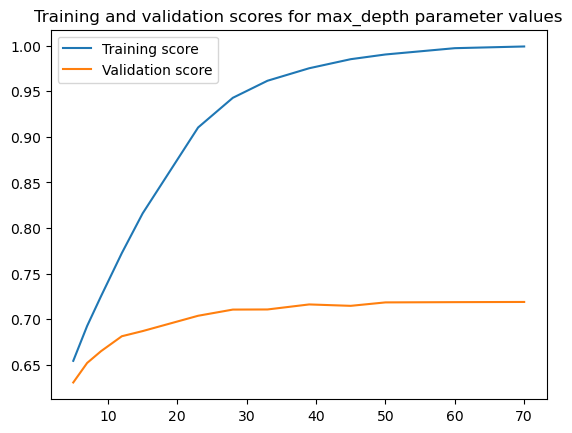

In [52]:
train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

plt.plot(param_range, train_scores_mean, label="Training score")
plt.plot(param_range, valid_scores_mean, label="Validation score")
plt.title('Training and validation scores for max_depth parameter values')
plt.legend()
plt.show()

This plot shows quite a noticeable difference in the training and validation scores. A max_depth value of around 23 is probably best. Anything more and the training score will be almost 1, which suggests overfitting, and the validation score won't improve much anyways. Anything less, and the validation score will suffer noticeably, suggesting underfitting.

### Evaluation Metrics for Random Forest

In [27]:
#so our best model is now the following
random_forest = RandomForestClassifier(random_state=42, n_estimators=125, min_samples_split=3, max_depth = 23)

random_forest.fit(X, y)

RandomForestClassifier(max_depth=23, min_samples_split=3, n_estimators=125,
                       random_state=42)

**Now lets get the accuracy scores.**

In [28]:
training_score_rf = random_forest.score(X, y)
testing_score_rf = random_forest.score(X_test, y_test)

print('Random forest training score:', random_forest.score(X, y))

print('Random forest testing score:', testing_score_rf)

Random forest training score: 0.898772150132552
Random forest testing score: 0.704331450094162


**Now lets get the f1 scores.**

In [29]:
y_pred = random_forest.predict(X_test)

f1_macro_rf = f1_score(y_test, y_pred, average='macro')
f1_weighted_rf = f1_score(y_test, y_pred, average='weighted')

print('The F1 score is:', f1_macro_rf)

print('The weighted F1 score is:', f1_weighted_rf)

The F1 score is: 0.47664493020068077
The weighted F1 score is: 0.6848591263404313


**Now lets get the log loss.**

In [45]:
y_pred_probs = random_forest.predict_proba(X_test)

rf_logloss = log_loss(y_test, y_pred_probs)

print('The log loss for random forest is:', rf_logloss)

The log loss for random forest is: 0.7202680886722377


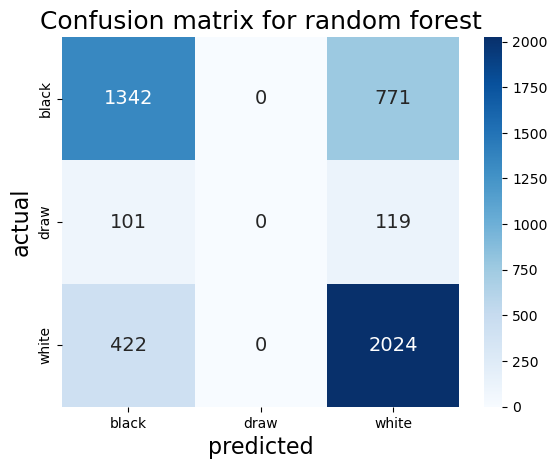

In [31]:
#now let's get the confusion matrix to see how it does
con_mat_rf = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat_rf, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for random forest', fontsize=18)
plt.show()

While you could already start to see that random forest was not as good as logistic regression here, the confusion matrix clearly shows the issue, in that it didn't predict draws ever.

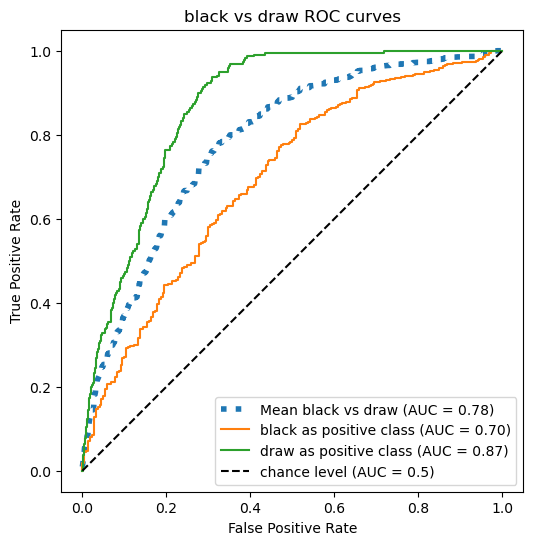

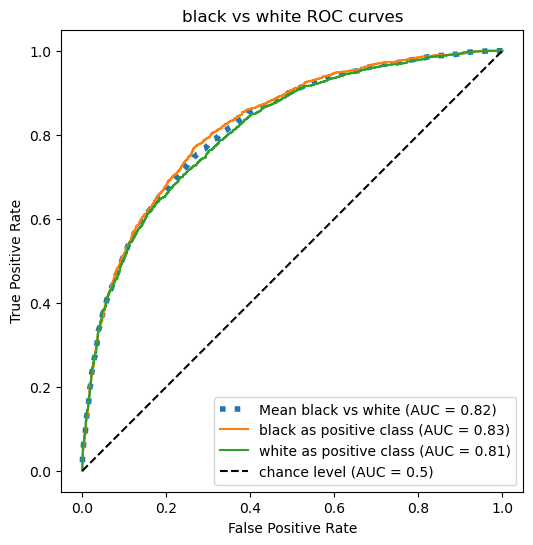

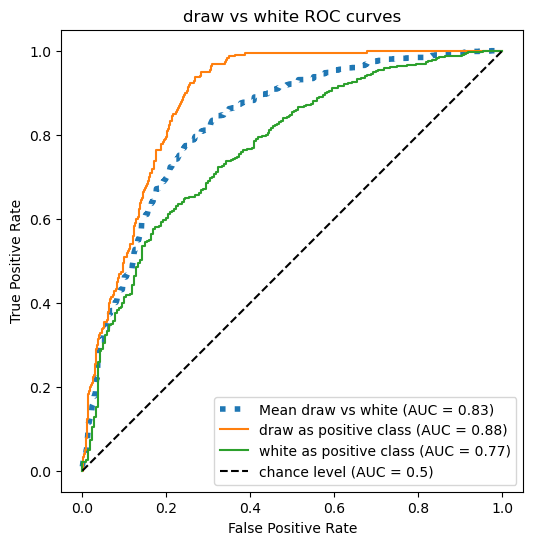

Macro-averaged One-vs-One ROC AUC score:
0.81


In [46]:
#just renaming a variable for ease - this is the only thing we need to run again,
#before getting the roc curves with the borrowed code below
y_score = y_pred_probs


pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)
    
    #modifying code to work with the labels in this dataset - just renaming from number to categries
    cat1 = {0:'black', 1:'draw', 2:'white'}[label_a]
    cat2 = {0:'black', 1:'draw', 2:'white'}[label_b]

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {cat1} vs {cat2} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{cat1} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{cat2} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")       
    plt.title(f"{target_names[idx_a]} vs {cat2} ROC curves")
    plt.legend()
    plt.show()

rf_1v1_auc = np.average(pair_scores)
print(f"Macro-averaged One-vs-One ROC AUC score:\n{rf_1v1_auc:.2f}")

**Some observations about the ROC AUC plots:** The black vs white ROC curves plot is similar to the logistic regression one, but slightly worse. When looking at the other curves, however, the AUC scores are significantly worse than logistic regression. In both cases where the draw label is the positive class, in order to get a high True positive rate, the False positive rate also needs to be quite high, meaning the model would predict too many games with white or black winners as draws. And then when the draw label is the negative class, both the white and black winner classes have even worse ROC curves and AUC scores. 

The averaged ROC AUC score is 0.81, which is not too bad. But again, the model not predicting draws at all is a problem. Although, if we made a model where we disregarded draws, it could be useful.

## Naive Bayes

In [136]:
nb = GaussianNB()

nb.fit(X, y)

GaussianNB()

In [137]:
nb.score(X, y)

0.5828798660527418

In [138]:
nb.score(X_test, y_test)

0.5024063611634233

This model seems to have done the worst. But now we can use Grid Search to assist in hyperparameter tuning.

In [20]:
#there are only two parameters to look at here, but it makes sense to leave the priors at the default value,
#since it adjusts itself according to the data (weighted based off of value counts)
parameters = {'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-8, 1e-10]}

nb = GaussianNB()

clf = GridSearchCV(nb, parameters)

clf.fit(X, y)

GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': [0.01, 0.0001, 1e-06, 1e-08, 1e-10]})

In [23]:
clf.score(X, y)

0.6414120273475652

In [24]:
clf.score(X_test, y_test)

0.6185394433982004

In [25]:
clf.best_params_

{'var_smoothing': 0.01}

These scores are not that great, but the var_smoothing parameter value has the largest as the best. Since there is only one hyperparameter to explore here, let's look at a validation curve, and modify the range of values to check by adding some larger ones.

In [31]:
model = GaussianNB()

train_scores, valid_scores = validation_curve(model, X, y, 
                                              param_name="var_smoothing", 
                                              param_range=[1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1, 1e1, 1e-2], 
                                              cv=5)

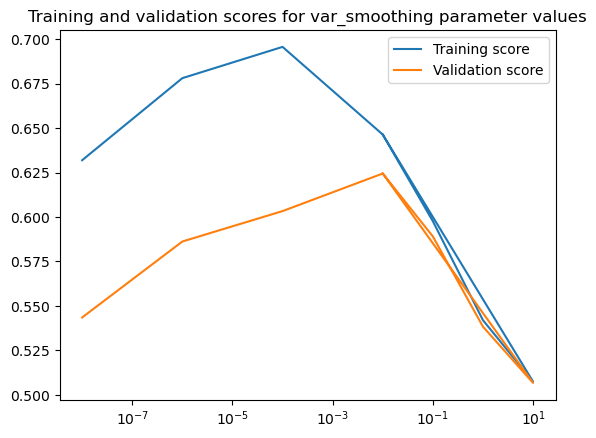

In [34]:
train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

#the var_smoothing parameter ranges increase exponentially, so we need to take the log of it to get a better visual
plt.semilogx([1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1, 1e1, 1e-2], train_scores_mean, label="Training score")
plt.semilogx([1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1, 1e1, 1e-2], valid_scores_mean, label="Validation score")
plt.title('Training and validation scores for var_smoothing parameter values')
plt.legend()
plt.show()

So from the above graph, you can see that the best value of var_smoothing is 0.01. Since that was the only parameter, we have our best GaussianNB model here. We can start looking at evaluation metrics alerady.

### GaussianNB Evaluation Metrics

In [38]:
gaussian_nb = GaussianNB(var_smoothing=0.01)

gaussian_nb.fit(X, y)

GaussianNB(var_smoothing=0.01)

In [39]:
training_score_nb = gaussian_nb.score(X, y)
testing_score_nb = gaussian_nb.score(X_test, y_test)

print('Gaussian Naive Bayes training score:', training_score_nb)

print('Gaussian Naive Bayes testing score:', testing_score_nb)

Gaussian Naive Bayes training score: 0.6414120273475652
Gaussian Naive Bayes testing score: 0.6185394433982004


These scores are a bit better than before, but now let's look at f1 scores.

**F1 scores.**

In [40]:
y_pred = gaussian_nb.predict(X_test)

f1_macro_nb = f1_score(y_test, y_pred, average='macro')
f1_weighted_nb = f1_score(y_test, y_pred, average='weighted')

print('The F1 score is:', f1_macro_nb)

print('The weighted F1 score is:', f1_weighted_nb)

The F1 score is: 0.5059217531965623
The weighted F1 score is: 0.6192570164627941


**Now the log loss**

In [41]:
y_pred_probs = gaussian_nb.predict_proba(X_test)

nb_logloss = log_loss(y_test, y_pred_probs)

print('The log loss for Gaussian Naive Bayes is:', nb_logloss)

The log loss for Gaussian Naive Bayes is: 8.890257750773586


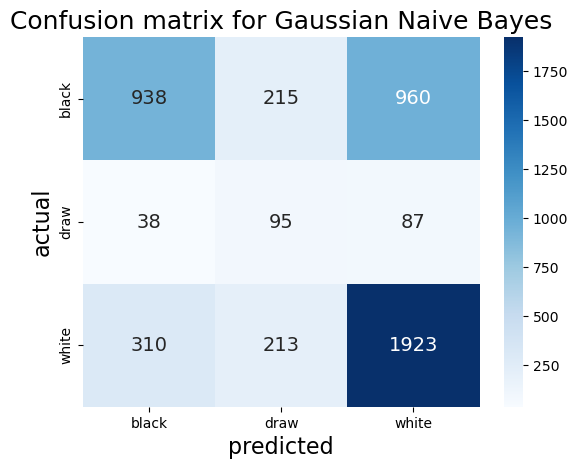

In [42]:
#now let's get the confusion matrix to see how it does
con_mat_nb = confusion_matrix(y_test, y_pred)

sns.heatmap(con_mat_nb, annot = True, fmt = 'g', cmap='Blues', annot_kws={"size": 14},
            xticklabels = ["black", "draw", "white"], yticklabels = ["black", "draw", "white"])
plt.xlabel('predicted', fontsize=16)
plt.ylabel('actual', fontsize=16)
plt.title('Confusion matrix for Gaussian Naive Bayes', fontsize=18)
plt.show()

This confusion matrix shows a similar problem that was in the EDA notebook, which is that the simple models favoured predicting white. In any case, in a way it is better than random forest because it predicts draws some of the time, but the accuracy score is just too low. Thus, this is clearly the weakest of the three models we've tried here.

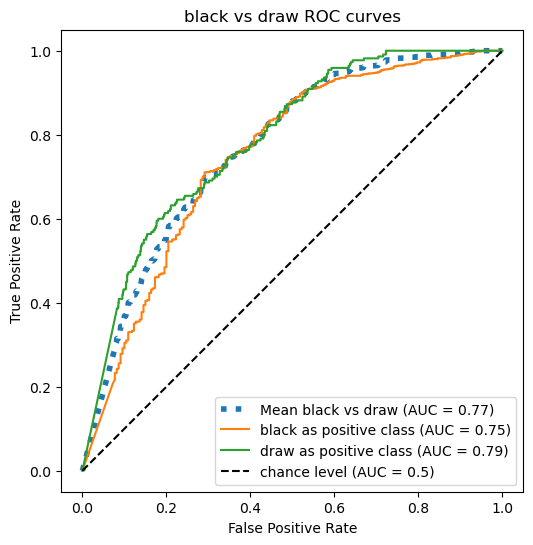

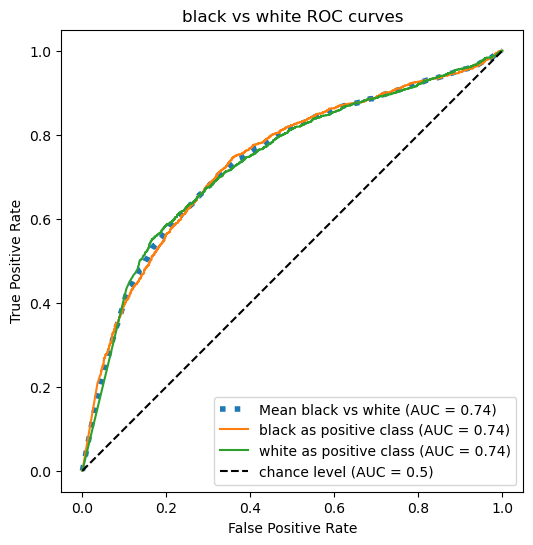

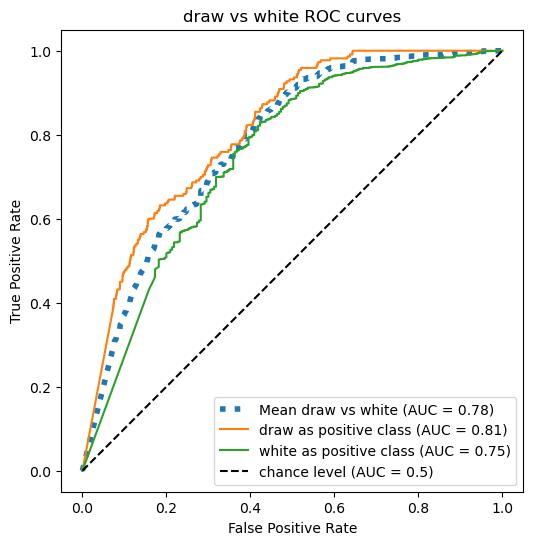

Macro-averaged One-vs-One ROC AUC score:
0.76


In [44]:
#just renaming a variable for ease - this is the only thing we need to run again,
#before getting the roc curves with the borrowed code below
y_score = y_pred_probs


pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)
    
    #modifying code to work with the labels in this dataset - just renaming from number to categries
    cat1 = {0:'black', 1:'draw', 2:'white'}[label_a]
    cat2 = {0:'black', 1:'draw', 2:'white'}[label_b]

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {cat1} vs {cat2} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{cat1} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{cat2} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")       
    plt.title(f"{target_names[idx_a]} vs {cat2} ROC curves")
    plt.legend()
    plt.show()

nb_1v1_auc = np.average(pair_scores)
print(f"Macro-averaged One-vs-One ROC AUC score:\n{nb_1v1_auc:.2f}")

**Some observations about the ROC AUC plots:** The black vs white ROC curves here look the same as both models above, but with moderately lower AUC scores (i.e. less then 0.1 difference). This isn't too bad, but the other two plots look similar, but with lower AUC scores as well. From the confusion matrix above, we know this model does predict draws, but this model's accuracy is overall too low. It seems the model incorrectly predicts draws more times than it correctly predicts it. The averaged AUC score is also only 0.76, making it the lowest of the three models so far.

## Comparing all the models

Let's now compare all the metrics of the models ar once.

In [56]:
#getting lists for all the metrics
train_acc = [log_reg_training_score, training_score_rf, training_score_nb]
test_acc = [log_reg_testing_score, testing_score_rf, training_score_nb]

f1_macro = [f1_macro_lr, f1_macro_rf, f1_macro_nb]
f1_weighted = [f1_weighted_lr, f1_weighted_rf, f1_weighted_nb]

log_losss = [log_reg_logloss, rf_logloss, nb_logloss]

roc_auc_scores = [lr_1v1_auc, rf_1v1_auc, nb_1v1_auc]

In [57]:
#make a dict out of these lists and turn it into a dataframe to easy visualization
metrics_dict = {'training accuracy': train_acc, 
               'testing accuracy': test_acc,
               'F1 score': f1_macro,
               'weighted F1 score': f1_weighted,
               'log loss': log_losss,
               'roc auc one vs one averaged scores': roc_auc_scores}

metrics_df = pd.DataFrame(metrics_dict)

In [58]:
#naming the indices by their respective model names
metrics_df = metrics_df.rename(index={0:'Logistic Regression', 1:'Random Forest', 2:'Gaussian Naive Bayes'})

In [59]:
metrics_df

,training accuracy,testing accuracy,F1 score,weighted F1 score,log loss,roc auc one vs one averaged scores
Logistic Regression,0.811148,0.765641,0.816002,0.765856,0.510630,0.926179
Random Forest,0.898772,0.704331,0.476645,0.684859,0.720268,0.810012
Gaussian Naive Bayes,0.641412,0.641412,0.505922,0.619257,8.890258,0.762507


Let's go through these one by one. The best training accuracy goes to the random forest model, but we already knew from before that it was overfitting. So looking at the best testing accuracy, not only does the Logistic Regression model have the best score, but it's difference from the training score is much better than the random forest. Thus both of these metrics have the best value when using the Logistic Regression algorithm.

Next, the F1 scores are easy. I included the weighted score to see if there would be a big change, since only one target label in this dataset was unbalanced, but it didn't make a difference. Both scores are best with the Logistic Regression model. 

And finally, both the log loss and roc_auc scores are best with the Logistic Regression as well, **thus making the Logistic Regression model the best model.**

In [88]:
print(log_reg)

LogisticRegression(C=0.1, max_iter=25, random_state=42, solver='newton-cg')
